# Storm Data Prediciton
## Group 1: Dhairya Dodia, Duncan Conley, Jameson Thomas
----------------------------------------------------------

### Step 0: Import libraries:

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

### Step 1: Load & Prep Data

In [66]:
file_path = "StormEvents_details-ftp_v1.0_d2024_c20250401.csv.gz"  # data

# Read the CSV file
df = pd.read_csv(file_path)

### --- FEATURE ENGINEER COLUMNS --- ###

# Combine BEGIN_LAT and END_LAT into a single LAT column
def combine_latitudes(row):
    if pd.notna(row['BEGIN_LAT']) and pd.notna(row['END_LAT']):
        return (row['BEGIN_LAT'] + row['END_LAT']) / 2  # LAT = Average (both present)
    elif pd.notna(row['BEGIN_LAT']):
        return row['BEGIN_LAT']  # LAT = BEGIN_LAT (END_LAT missing)
    elif pd.notna(row['END_LAT']):
        return row['END_LAT']  # LAT = END_LAT (BEGIN_LAT missing)
    else:
        return np.nan  # Return NaN (both missing)

# Combine BEGIN_LON and END_LON into a single LON column
def combine_longitudes(row):
    if pd.notna(row['BEGIN_LON']) and pd.notna(row['END_LON']):
        return (row['BEGIN_LON'] + row['END_LON']) / 2  # LON = Average (both present)
    elif pd.notna(row['BEGIN_LON']):
        return row['BEGIN_LON']  # LON = BEGIN_LON (END_LON missing)
    elif pd.notna(row['END_LON']):
        return row['END_LON']  # LON = END_LON (BEGIN_LON missing)
    else:
        return np.nan  # Return NaN (both missing)

# Combine BEGIN_DATE_TIME and END_DATE_TIME into a single ELAPSED_TIME_MIN column
def calculate_elapsed_minutes(row):
    # Convert the strings to datetime objects using the correct format
    begin_time = pd.to_datetime(row['BEGIN_DATE_TIME'], format="%d-%b-%y %H:%M:%S", errors='coerce')
    end_time = pd.to_datetime(row['END_DATE_TIME'], format="%d-%b-%y %H:%M:%S", errors='coerce')
    
    # If either conversion fails, return NaN
    if pd.isna(begin_time) or pd.isna(end_time):
        return np.nan

    # Compute the elapsed time in minutes and return as an integer
    elapsed = end_time - begin_time
    return int(elapsed.total_seconds() // 60)

def convert_damage(value):
    if pd.isna(value):
        return 0  # Handle NaN values
    value = str(value).upper().strip()  # Ensure the value is uppercase and clean
    if value.endswith('K'):  # Thousands
        try:
            return float(value[:-1]) * 1e3
        except ValueError:
            return 0
    # Optionally, handle other cases (e.g., values ending in 'M' for millions)
    try:
        return float(value)
    except ValueError:
        return 0

# Drop all rows in which there is no DAMAGE_PROPERTY
df = df[pd.notna(df['DAMAGE_PROPERTY'])]

# Convert damage values to numeric
df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].apply(convert_damage)
df['DAMAGE_CROPS'] = df['DAMAGE_CROPS'].apply(convert_damage)
df['DAMAGE_PROPERTY'] = pd.to_numeric(df['DAMAGE_PROPERTY'], errors='coerce')

# Create new columns from longitudes, latitudes, and elapsed time
df['LAT'] = df.apply(combine_latitudes, axis=1)
df['LON'] = df.apply(combine_longitudes, axis=1)
df['ELAPSED_TIME_MIN'] = df.apply(calculate_elapsed_minutes, axis=1)

# Drop unnecessary columns
df = df.drop(columns=['EVENT_TYPE'])

# Verify the result
#print(df.columns)
df = df.drop(columns=[
    'CZ_TYPE', 'CZ_FIPS', 'EPISODE_ID', 'EVENT_ID', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
    'DATA_SOURCE', 'SOURCE', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
    'DEATHS_INDIRECT', 'FLOOD_CAUSE', 'MONTH_NAME', 'BEGIN_DAY', 'BEGIN_TIME', 'END_DAY', 'END_TIME',
    'CZ_NAME', 'WFO', 'CZ_TIMEZONE', 'BEGIN_RANGE', 'BEGIN_DATE_TIME', 'END_DATE_TIME',
    'TOR_OTHER_CZ_NAME', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_WFO',
    'END_RANGE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LON', 'END_LON', 'BEGIN_LAT', 'END_LAT', 'BEGIN_LOCATION', 'END_LOCATION',
    'BEGIN_YEARMONTH', 'END_YEARMONTH', 'STATE', 'STATE_FIPS', 'YEAR', 'CATEGORY', 'MAGNITUDE_TYPE',
])

# Print columns used
print(df.columns)


Index(['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'LAT', 'LON', 'ELAPSED_TIME_MIN'],
      dtype='object')


In [67]:
# Create the damage category using pd.cut; include the lowest value in the first bin.
# bins = np.linspace(df['DAMAGE_PROPERTY'].min(), df['DAMAGE_PROPERTY'].max(), num=4)
# labels = ['low', 'medium', 'high']
# df['DAMAGE_CATEGORY'] = pd.cut(df['DAMAGE_PROPERTY'], bins=bins, labels=labels, include_lowest=True)
bins = np.percentile(df['DAMAGE_PROPERTY'], [0, 50, 100])
print("Bin edges:", bins)
#labels = ['low', 'medium', 'high', 'very high']
df['DAMAGE_CATEGORY'] = pd.qcut(
    df['DAMAGE_PROPERTY'], 
    q=4,  # Number of quantiles
    labels=['low', 'high'], 
    duplicates='drop'  # Drop duplicate bin edges
)

print(df['DAMAGE_CATEGORY'].value_counts())


# --- ENCODE CATEGORICAL VARIABLES --- #
# List of categorical columns that you want to include as features
categorical_columns = [ 'MAGNITUDE_TYPE', 'TOR_F_SCALE']

# Use get_dummies to convert categorical columns to dummy/indicator variables.
#encoded_cats = pd.get_dummies(df[categorical_columns], drop_first=True)

# --- PREPARE FEATURE MATRIX --- #
# Select the numeric columns and drop any that are not desired as features.
numeric_columns = df.select_dtypes(include=[np.number]).columns
X_numeric = df[numeric_columns].drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS'])

# Combine numeric features with the encoded categorical features.
#X_full = pd.concat([X_numeric, encoded_cats], axis=1)

# Impute missing values in the feature matrix
imputer = SimpleImputer(strategy='median')
#

# The target remains your damage category.
y = df['DAMAGE_CATEGORY'].values

# Check for NaN values in the feature matrix
#print("NaNs in X after imputation:", np.isnan(X_full).any())

# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Confirm that there are no NaN values in the splits.
print("NaNs in X_train:", np.isnan(X_train).any())
print("NaNs in X_test:", np.isnan(X_test).any())

Bin edges: [      0.       0. 8000000.]
DAMAGE_CATEGORY
low     41176
high    13686
Name: count, dtype: int64
NaNs in X_train: MAGNITUDE            True
TOR_LENGTH           True
TOR_WIDTH            True
LAT                  True
LON                  True
ELAPSED_TIME_MIN    False
dtype: bool
NaNs in X_test: MAGNITUDE            True
TOR_LENGTH           True
TOR_WIDTH            True
LAT                  True
LON                  True
ELAPSED_TIME_MIN    False
dtype: bool


# Create Decision Tree


Accuracy: 0.8509979039460493
Classification Report:
               precision    recall  f1-score   support

        high       0.74      0.63      0.68      2730
         low       0.88      0.93      0.90      8243

    accuracy                           0.85     10973
   macro avg       0.81      0.78      0.79     10973
weighted avg       0.85      0.85      0.85     10973



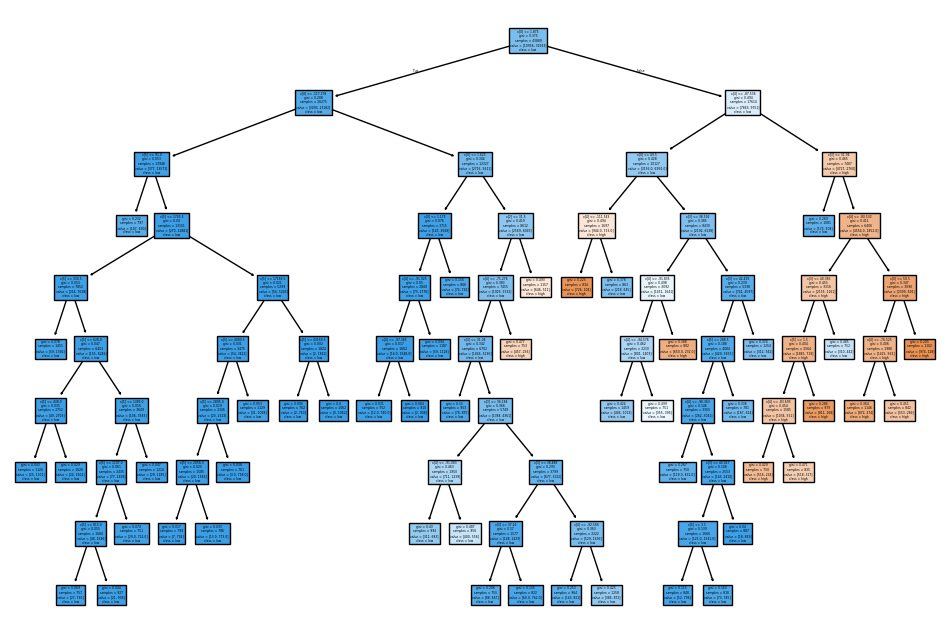

In [68]:
# Train the Decision Tree Classifier.
clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=750)
clf.fit(X_train, y_train)

# Predict on the test set and evaluate the model.
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize the decision tree.
plt.figure(figsize=(12, 8))

# For plotting, combine feature names for numeric and dummy variables.
numeric_feature_names = X_numeric.columns.tolist()
#categorical_feature_names = encoded_cats.columns.tolist()
#feature_names = numeric_feature_names + categorical_feature_names

plot_tree(clf, class_names=clf.classes_, filled=True)
plt.show()

#print("Columns used in the model:" + numeric_feature_names)




# Feature Engineering


# Clustering

# Most association with different features

# Decision Tree Regressor

Accuracy: 0.8884534767155746
Classification Report:
               precision    recall  f1-score   support

        high       0.84      0.68      0.75      2730
         low       0.90      0.96      0.93      8243

    accuracy                           0.89     10973
   macro avg       0.87      0.82      0.84     10973
weighted avg       0.89      0.89      0.88     10973

Confusion Matrix:
 [[1858  872]
 [ 352 7891]]
Shape of X: (54862, 6)
Shape of y: (54862,)
Missing values in X: False
Missing values in y: False
Feature Importances:
MAGNITUDE: 0.2453
MAGNITUDE_TYPE: 0.0104
TOR_F_SCALE: 0.0116
TOR_LENGTH: 0.2262
TOR_WIDTH: 0.3219
LAT: 0.1847


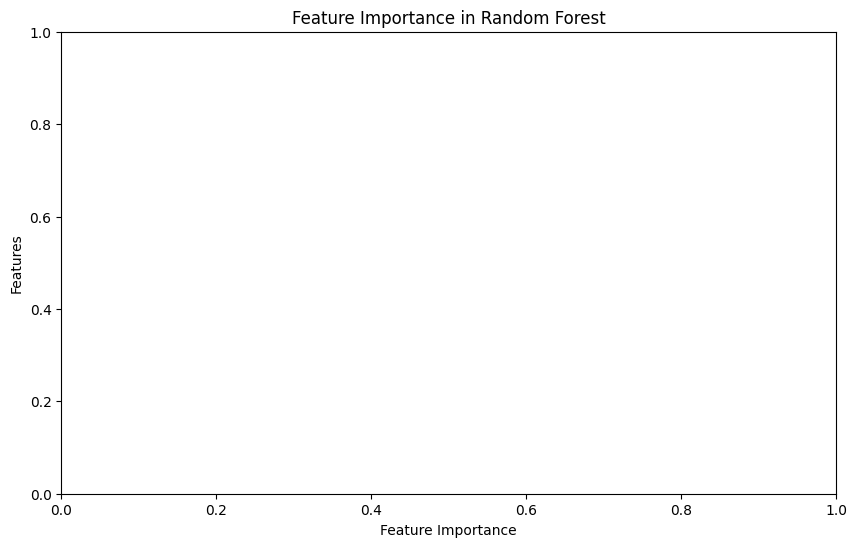

KeyboardInterrupt: 

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Prepare Features and Target --- #
# Select numeric columns for features
numeric_columns = df.select_dtypes(include=[np.number]).columns
X = df[numeric_columns].drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS']).values  # Features
y = df['DAMAGE_CATEGORY'].values  # Target variable (categorical)

# Impute missing values in X
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Drop rows with missing target values
df = df.dropna(subset=['DAMAGE_CATEGORY'])
y = df['DAMAGE_CATEGORY'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train the Random Forest Classifier --- #
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=5)
rf_clf.fit(X_train, y_train)

# --- Make Predictions --- #
y_pred = rf_clf.predict(X_test)

# --- Evaluate the Model --- #
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

importances = rf_clf.feature_importances_
feature_names = df.drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'DAMAGE_CATEGORY']).columns

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

print("Missing values in X:", np.isnan(X).any())
print("Missing values in y:", pd.isna(y).any())

import seaborn as sns

# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': importances
# }).sort_values(by='Importance', ascending=False)


print("Feature Importances:")
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")
# Plot Feature Importance
plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.show()

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)